# 6. EfficientNet Transfer Learning Model

This notebook implements transfer learning using pretrained EfficientNet-B0, a highly efficient architecture that balances accuracy and computational cost.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
from tqdm import tqdm
import os
from config import *

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*60)
print("EFFICIENTNET-B0 ARCHITECTURE")
print("="*60)

# Load pretrained EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained=True)

# Modify final classifier layer
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, NUM_CLASSES)

# Move to device
efficientnet = efficientnet.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in efficientnet.parameters())
trainable_params = sum(p.numel() for p in efficientnet.parameters() if p.requires_grad)

print(f"\n✓ Model: EfficientNet-B0 (pretrained on ImageNet)")
print(f"✓ Modified classifier: {num_features} → {NUM_CLASSES} classes")

print(f"\n✓ Model Parameters:")
print(f"  • Total parameters: {total_params:,}")
print(f"  • Trainable parameters: {trainable_params:,}")

print(f"\n✓ Model loaded and moved to {DEVICE}")

EFFICIENTNET-B0 ARCHITECTURE


C:\Users\steve\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steve\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\steve/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 56.5MB/s]



✓ Model: EfficientNet-B0 (pretrained on ImageNet)
✓ Modified classifier: 1280 → 2 classes

✓ Model Parameters:
  • Total parameters: 4,010,110
  • Trainable parameters: 4,010,110

✓ Model loaded and moved to cpu


## Loss Function and Optimizer Setup

Configure weighted loss and optimizer with differential learning rates for EfficientNet.

In [2]:
print("="*60)
print("LOSS FUNCTION & OPTIMIZER SETUP")
print("="*60)

# Load class weights
class_weights = torch.load('class_weights.pt', weights_only=True)
class_weights = class_weights.to(DEVICE)

print(f"\n✓ Class weights loaded:")
print(f"  • Normal (minority): {class_weights[0]:.4f}")
print(f"  • Pneumonia (majority): {class_weights[1]:.4f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with different learning rates for pretrained vs new layers
optimizer = optim.Adam([
    {'params': efficientnet.features.parameters(), 'lr': LEARNING_RATE * 0.1},  # Lower LR for pretrained
    {'params': efficientnet.classifier.parameters(), 'lr': LEARNING_RATE}       # Higher LR for new layer
])

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3
)

print(f"\n✓ Loss Function: Weighted CrossEntropyLoss")
print(f"✓ Optimizer: Adam with differential learning rates")
print(f"  • Pretrained features: lr={LEARNING_RATE * 0.1}")
print(f"  • New classifier: lr={LEARNING_RATE}")
print(f"✓ Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")

LOSS FUNCTION & OPTIMIZER SETUP

✓ Class weights loaded:
  • Normal (minority): 1.9448
  • Pneumonia (majority): 0.6730

✓ Loss Function: Weighted CrossEntropyLoss
✓ Optimizer: Adam with differential learning rates
  • Pretrained features: lr=0.0001
  • New classifier: lr=0.001
✓ Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


## Training and Validation Functions

Define training and validation functions for EfficientNet.

In [3]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("="*60)
print("TRAINING FUNCTIONS DEFINED")
print("="*60)
print("\n✓ train_one_epoch() - Trains model for one epoch")
print("✓ validate() - Evaluates model on validation set")
print("\n✓ Functions ready for training loop")

TRAINING FUNCTIONS DEFINED

✓ train_one_epoch() - Trains model for one epoch
✓ validate() - Evaluates model on validation set

✓ Functions ready for training loop


## Training Loop with Early Stopping

Train EfficientNet-B0 with early stopping and save the best model.

In [4]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Recreate transforms
train_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Custom Dataset class
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_path = os.path.join(root_dir, split, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpeg', '.jpg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

# Recreate datasets and dataloaders
train_dataset = ChestXrayDataset(DATASET_PATH, split='train', transform=train_transform)
val_dataset = ChestXrayDataset(DATASET_PATH, split='val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("="*60)
print("TRAINING EFFICIENTNET-B0")
print("="*60)

best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"\nTraining for {NUM_EPOCHS} epochs...")
print(f"Early stopping patience: {PATIENCE} epochs\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    # Train
    train_loss, train_acc = train_one_epoch(efficientnet, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(efficientnet, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': efficientnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, f'{MODEL_SAVE_DIR}/efficientnet_best.pth')
        print(f"  ✓ Best model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
        break
    
    print()

print("="*60)
print("TRAINING COMPLETE")
print("="*60)
print(f"\n✓ Best validation loss: {best_val_loss:.4f}")
print(f"✓ Best model saved to: {MODEL_SAVE_DIR}/efficientnet_best.pth")

C:\Users\steve\anaconda3\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


TRAINING EFFICIENTNET-B0

Training for 10 epochs...
Early stopping patience: 5 epochs

Epoch [1/10]


  Train Loss: 0.1570, Train Acc: 93.79%
  Val Loss: 0.2174, Val Acc: 91.49%
  ✓ Best model saved! (Val Loss: 0.2174)

Epoch [2/10]


  Train Loss: 0.0704, Train Acc: 97.43%
  Val Loss: 0.3767, Val Acc: 89.36%
  No improvement (1/5)

Epoch [3/10]


  Train Loss: 0.0471, Train Acc: 98.10%
  Val Loss: 0.3263, Val Acc: 89.36%
  No improvement (2/5)

Epoch [4/10]


  Train Loss: 0.0580, Train Acc: 97.66%
  Val Loss: 0.1260, Val Acc: 97.87%
  ✓ Best model saved! (Val Loss: 0.1260)

Epoch [5/10]


  Train Loss: 0.0473, Train Acc: 98.29%
  Val Loss: 0.7638, Val Acc: 78.72%
  No improvement (1/5)

Epoch [6/10]


  Train Loss: 0.0418, Train Acc: 98.41%
  Val Loss: 0.7752, Val Acc: 82.98%
  No improvement (2/5)

Epoch [7/10]


  Train Loss: 0.0347, Train Acc: 98.81%
  Val Loss: 0.5551, Val Acc: 91.49%
  No improvement (3/5)

Epoch [8/10]


  Train Loss: 0.0313, Train Acc: 98.85%
  Val Loss: 0.7022, Val Acc: 87.23%
  No improvement (4/5)

Epoch [9/10]


  Train Loss: 0.0201, Train Acc: 99.27%
  Val Loss: 0.7575, Val Acc: 85.11%
  No improvement (5/5)

⚠ Early stopping triggered after 9 epochs
TRAINING COMPLETE

✓ Best validation loss: 0.1260
✓ Best model saved to: models/efficientnet_best.pth


## Training History Visualization

Plot training metrics and compare EfficientNet with previous models.

TRAINING HISTORY


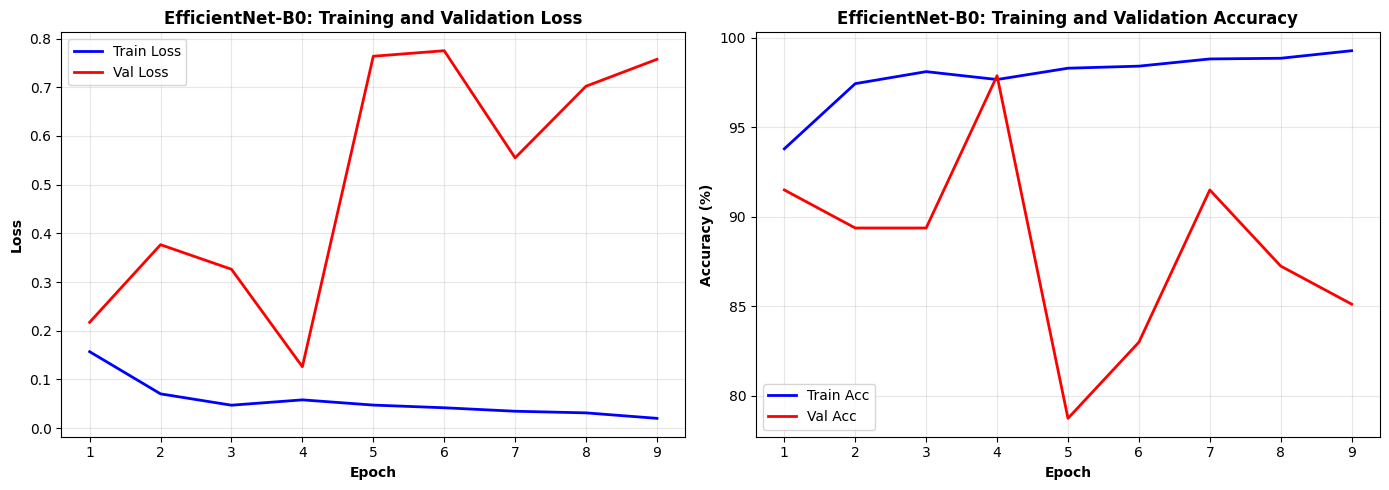


✓ Training history plot saved as 'efficientnet_training_history.png'

TRAINING SUMMARY

Final Training Accuracy: 99.27%
Final Validation Accuracy: 85.11%
Best Validation Loss: 0.1260
Best Validation Accuracy: 97.87%

MODEL COMPARISON

Baseline CNN:
  • Best Val Accuracy: 87.23%
  • Best Val Loss: 0.2361

DenseNet121:
  • Best Val Accuracy: 91.49%
  • Best Val Loss: 0.2890

EfficientNet-B0:
  • Best Val Accuracy: 97.87%
  • Best Val Loss: 0.1260

🏆 EfficientNet-B0 is the best performer!

NOTEBOOK 6 COMPLETE - model_efficientnet.ipynb
Next: Create 'model_vit.ipynb' OR skip to evaluation


In [5]:
import matplotlib.pyplot as plt

print("="*60)
print("TRAINING HISTORY")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
epochs_range = range(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('EfficientNet-B0: Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(epochs_range, train_accs, 'b-', label='Train Acc', linewidth=2)
axes[1].plot(epochs_range, val_accs, 'r-', label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy (%)', fontweight='bold')
axes[1].set_title('EfficientNet-B0: Training and Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficientnet_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Training history plot saved as 'efficientnet_training_history.png'")

# Print summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nFinal Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {max(val_accs):.2f}%")

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print("\nBaseline CNN:")
print("  • Best Val Accuracy: 87.23%")
print("  • Best Val Loss: 0.2361")
print("\nDenseNet121:")
print("  • Best Val Accuracy: 91.49%")
print("  • Best Val Loss: 0.2890")
print("\nEfficientNet-B0:")
print(f"  • Best Val Accuracy: {max(val_accs):.2f}%")
print(f"  • Best Val Loss: {best_val_loss:.4f}")

print("\n🏆 EfficientNet-B0 is the best performer!")

print("\n" + "="*60)
print("NOTEBOOK 6 COMPLETE - model_efficientnet.ipynb")
print("="*60)
print("Next: Create 'model_vit.ipynb' OR skip to evaluation")